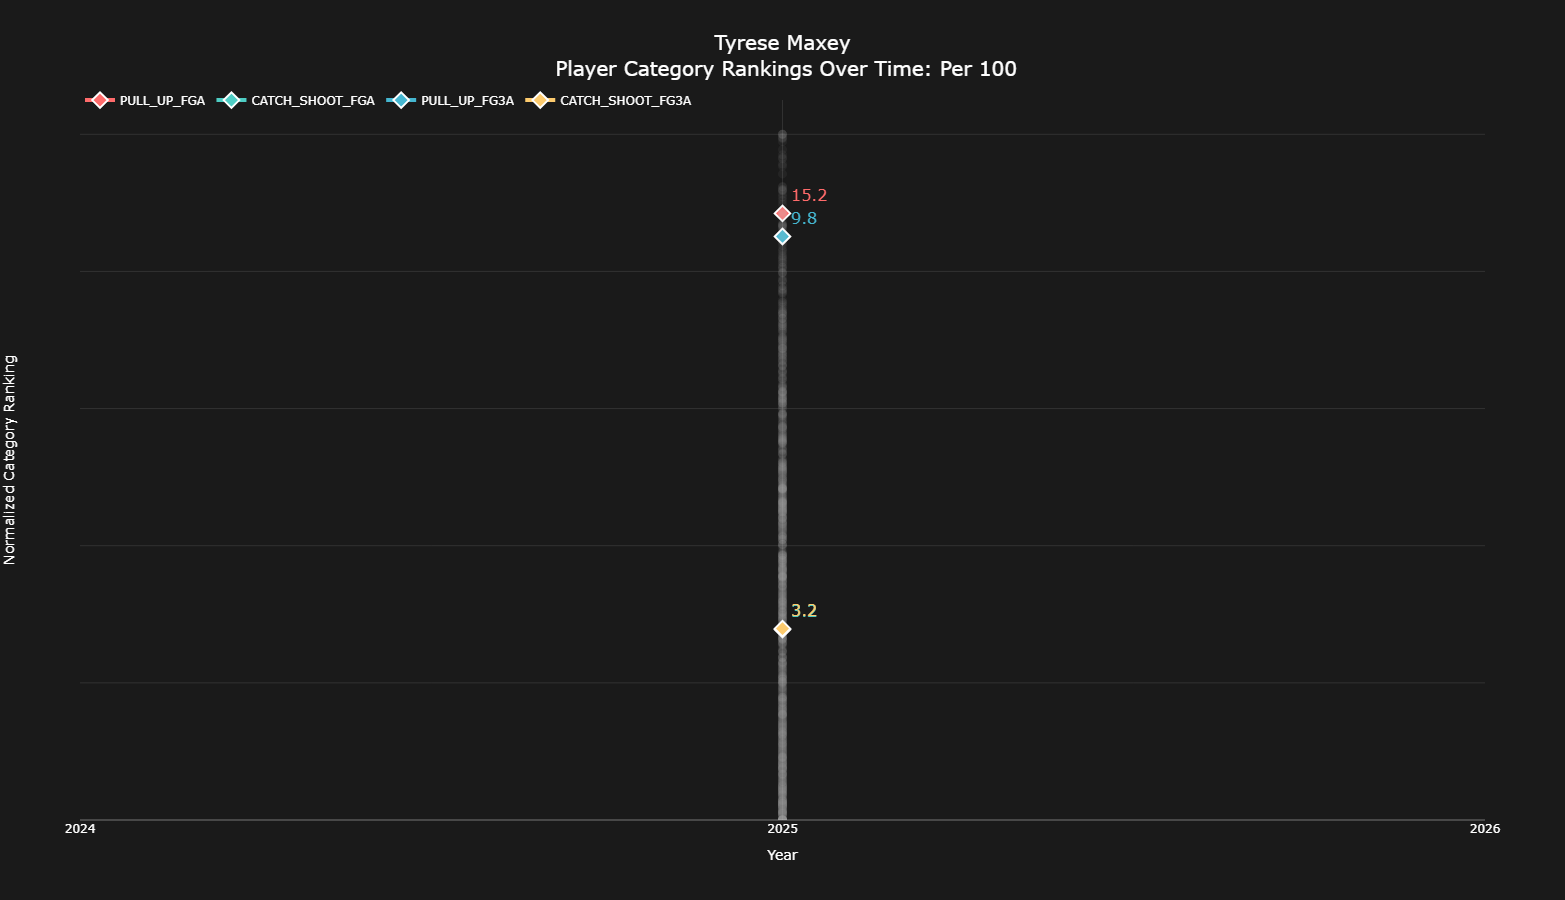

In [19]:
import pandas as pd
import pandas as pd
import pandas as pd
import numpy as np
from nba_api.stats.static import players

import time 
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import json

def category_shift(player_id, start_year, end_year, categories, selected_rate, ps=False):
    """
    Create a Plotly visualization of a player's category rankings across years with enhanced styling.
    
    Parameters:
    - player_id (int): The unique ID of the player to highlight
    - start_year (int): Beginning of the year range
    - end_year (int): End of the year range (exclusive)
    - categories (list): List of statistical categories to visualize
    - selected_rate (str): Rate of statistic ('Per 100' or 'Per Game')
    - ps (bool): Whether to use playoff stats (default: False)
    
    Returns:
    - Plotly Figure object
    """
    team_names = {
        "PHX": "Phoenix Suns", "DET": "Detroit Pistons", "POR": "Portland Trail Blazers",
        "MIL": "Milwaukee Bucks", "BOS": "Boston Celtics", "LAL": "Los Angeles Lakers",
        "ORL": "Orlando Magic", "NOP": "New Orleans Pelicans", "NOH": "New Orleans Pelicans",
        "DAL": "Dallas Mavericks", "DEN": "Denver Nuggets", "IND": "Indiana Pacers",
        "CHA": "Charlotte Hornets", "CHH": "Charlotte Hornets", "SAS": "San Antonio Spurs",
        "LAC": "Los Angeles Clippers", "MEM": "Memphis Grizzlies", "WAS": "Washington Wizards",
        "MIA": "Miami Heat", "ATL": "Atlanta Hawks", "OKC": "Oklahoma City Thunder",
        "SEA": "Seattle Supersonics", "UTA": "Utah Jazz", "NYK": "New York Knicks",
        "CHI": "Chicago Bulls", "MIN": "Minnesota Timberwolves", "NJN": "New Jersey Nets",
        "BKN": "Brooklyn Nets", "BRK": "Brooklyn Nets", "CLE": "Cleveland Cavaliers",
        "HOU": "Houston Rockets", "GSW": "Golden State Warriors", "SAC": "Sacramento Kings",
        "TOR": "Toronto Raptors", "PHI": "Philadelphia 76ers"
    }
    
    # Prepare addon for file path based on regular or playoff stats
    addon = ' PS ' if ps else ' RS '
    
    # Prepare columns to read
    columns_to_read = ['POSS', 'GP', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'MIN', 'PLAYER_ID']
    columns_to_read.extend(categories)
    
    # Fetch and combine data for the specified year range
    frames = []
    for year in range(start_year, end_year+1):
        file_path = 'https://raw.githubusercontent.com/gabriel1200/player_sheets/refs/heads/master/year_totals/'
        link = file_path + str(year) + '.csv'
        df = pd.read_csv(link, usecols=columns_to_read)
        df['year'] = year
        df['PLAYER_ID']=df['PLAYER_ID'].astype(int)
        frames.append(df)
    data = pd.concat(frames)
    # Rate conversion
    for cat in categories:
        if 'accuracy' in cat.lower() or 'pct' in cat.lower() or 'freq' in cat.lower():
            data[cat]*=100

        else:
            if selected_rate == 'Per 100':
                data[cat] = 100 * data[cat] / data['POSS']
            elif selected_rate == 'Per Game':
                data[cat] = data[cat] / data['GP']
    
    # Filter for players with sufficient games played (minimum 20 games)
    data = data[data['GP'] >= 10]
    
    # Get the specific player's data
    player_data = data[data['PLAYER_ID'] == player_id]
    
    # Normalize each category across years with percentile calculation
    def normalize_category(category):
        # Normalize to full range, including outliers
        cat_data = data[category]
        
        # Normalize to 0-1 range using min-max scaling
        normalized = (cat_data - cat_data.min()) / (cat_data.max() - cat_data.min())
        
        # Calculate percentile ranks
        percentile_ranks = (normalized.rank(method='average') - 1) / (len(normalized) - 1) * 100
        
        return normalized, percentile_ranks
    
    # Create normalized dataframe and percentile ranks
    normalized_data = {}
    percentile_ranks = {}
    for cat in categories:
        normalized_data[cat], percentile_ranks[cat] = normalize_category(cat)
        data[f'{cat}_normalized'] = normalized_data[cat]
        data[f'{cat}_percentile'] = percentile_ranks[cat]
        
        
        # Prepare traces for each category
        traces = []
        color_palette = [
            '#FF6B6B',   # Vibrant Red
            '#4ECDC4',   # Turquoise
            '#45B7D1',   # Sky Blue
            '#FDCB6E',   # Soft Yellow
            '#6C5CE7',   # Purple
            '#A8E6CF',   # Mint Green
        ]
    bg_color = '#1a1a1a'
    
    for i, cat in enumerate(categories):
        # Other players trace (faded)
        other_players = data[data['PLAYER_ID'] != player_id]
        other_trace = go.Scatter(
            x=other_players['year'],
            y=other_players[f'{cat}_normalized'],
            mode='markers',
            name=f'Other Players - {cat}',
            line=dict(color='rgba(200,200,200,0.2)', width=1),
            marker=dict(color='rgba(200,200,200,0.2)', size=9),
            opacity=0.3,

            hoverinfo='none',

            showlegend=False
            
        )
        traces.append(other_trace)
        
        # Highlighted player trace
        player_cat_data = data[data['PLAYER_ID'] == player_id]
        player_trace = go.Scatter(
            x=player_cat_data['year'],
            y=player_cat_data[f'{cat}_normalized'],
            text=player_cat_data[cat].round(1).astype(str),

            mode='markers+lines+text',
            name=f'{cat}',
            line=dict(color=color_palette[i % len(color_palette)], width=4, dash='solid'),
            
            marker=dict(
                size=12, 
                color=color_palette[i % len(color_palette)], 
                symbol='diamond',
                line=dict(color='white', width=2)
            ),
            textfont=dict(
                color=color_palette[i % len(color_palette)],
                size=16
            ),
            textposition='top right', 
            hovertemplate=
            '<b>Year</b>: %{x}<br>' +
            '<b>Normalized Rank</b>: %{y:.3f}<br>' +
            '<b>Percentile Rank</b>: %{customdata[1]:.1f}%<br>' +
            '<b>Actual Value</b>: ' + cat + ': %{customdata[0]:.2f}<extra></extra>',
            customdata=list(zip(player_cat_data[cat], player_cat_data[f'{cat}_percentile']))
        )
        traces.append(player_trace)
    
    # Create the layout with dark theme
    layout = go.Layout(
        title={
            'text': f'{player_data["PLAYER_NAME"].iloc[0]}<br> Player Category Rankings Over Time: '+selected_rate,
            'font': {'color': 'white', 'size': 20},
            'x': 0.5,
            'xanchor': 'center'
        },

        plot_bgcolor=bg_color,
        paper_bgcolor=bg_color,
        xaxis=dict(
            title='Year', 
            tickmode='linear',
            gridcolor='rgba(255,255,255,0.1)',
            tickfont=dict(color='white'),
            title_font=dict(color='white'),
            zerolinecolor='rgba(255,255,255,0.2)',
          
        ),
        yaxis=dict(
            title='Normalized Category Ranking', 
            range=[0, 1.05],
            gridcolor='rgba(255,255,255,0.1)',
            tickfont=dict(color='white'),
            title_font=dict(color='white'),
            zerolinecolor='rgba(255,255,255,0.2)',
             showticklabels=False, 
        ),
        hovermode='closest',
        legend=dict(
            orientation="h", 
         
            y=1.02, 
       
            x=0,
            font=dict(color='white')
        ),
        height=900,
        width=1350
    )
    
    # Create and return the figure
    fig = go.Figure(data=traces, layout=layout)
    return fig
player_id=1630178
start_year=2025
end_year = 2025
categories=['PULL_UP_FGA','CATCH_SHOOT_FGA','PULL_UP_FG3A','CATCH_SHOOT_FG3A']
selected_rate='Per 100'
fig = category_shift(player_id, start_year, end_year, categories, selected_rate, ps=False)
fig.show()